**This example is used to demostrate the tool**

In [1]:
#Import our modules
import Service
import GlOb
import Comm 
import exeAreas
import exeMgn

#import modules for API
from API import srcAPI as src
from API import sinkAPI as sink
from API import FMUAPI
from API import MatlabAPI
from API import PythonAPI
#import necessary services such as Server to connect remote components
from API.comm_protos.TCP import TCPServer as Server

#import general modules from python
import time
import os

In [2]:
#import libraries from  models that are created in Pyton
#Models made in python
from Models import SpringProp

#import dataProcess unit also made in python.. with the rules stated in the code
from Models.dataProcess import CurrentSens

In [3]:
#Create all  interfaces

directory = os.getcwd() + '\\' + 'Models'

############## sensor inteface ###########################################
sens = src.Sensor(name  = 'current_sensor', config = {"type" : "freq", 'unit': 's', 'occurrences_per_unit':2},
                    sending_port = 55000, receiving_ports = [55001], 
                    outputsNames = ['current'])
sensName = 'current_sensor'
sens.save_to_csv(file_name=sensName)

############### Sink interface ##################################################
monitor = sink.Sink (comm_proto = 'TCP-IP', 
                    name  = 'coil_monitor', config = {"type" : "freq", "unit": "s", "occurrences_per_unit":1},
                    instruction_port = 60000, sending_ports=[60001, 60002,60003], 
                    inputsNames = ['position', 'mass','T_coil'])
sinkName =  "coil_monitor"
monitor.save_to_csv(file_name=sinkName)

################### Data Process unit interface

DatProcc = CurrentSens()
DataProc = PythonAPI.Wrapping(model = DatProcc,directory=directory,
                                 modelName = 'DPCurrentSens', typ = 'DataProc',
                                 inputsNames= ['rawData'], outputsNames= ['eCurrent'])
DP_name = 'DPCurrentSens'
DataProc.save_to_csv(file_name=DP_name)
######################################### Python model ########################################

#create python object from the model
SProperty_model = SpringProp.Model()

#Encapsulate the model to store its attributes 
inputsNames = ['R']
outputsNames = ['T_coil','k']
springProp_model = PythonAPI.Wrapping(model=SProperty_model, directory=directory,
                                      modelName='SpringProp',inputsNames=inputsNames, 
                                      outputsNames=outputsNames, exeSchedule={1:'execute'},
                                      printFlag=True)

SprinP_name = 'SpringProp'
springProp_model.save_to_csv(file_name=SprinP_name)
########################################### FMU Models #########################################
#not really needed for FMUs:

ElectricalHeat = FMUAPI.FMU(modelName='ElectricalHeat', directory=directory)

MassSpringKInput = FMUAPI.FMU(modelName='MassSpringKInput', directory=directory)

RiceCooker = FMUAPI.FMU(modelName='RiceCooker', directory=directory)

Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model
{'ports': ['R', 'Tcoil', 'k', 'param'], 'methods': ['Tcoil_calculation', 'execute', 'k_calculation']}


In [4]:
#Component Manager

#instanciate all the components: by defining inputs, outputs and parameters 
# always as a dictionary {'name': , 'unit': , 'datatype'}


####################### #sensor component #########################################
output = {'name':"current", 'unit':'Amp', 'datatype':'JSON','val':''}
outputs = [output]

current_sens = Comm.Source(name = 'current_sensor',outputs = outputs)

################################ sink component #####################################
# 'position', 'mass','T_coil'
input1 = {'name':"position", 'unit':'m', 'datatype':'float','val':''}
input2 = {'name':"mass", 'unit':'kg', 'datatype':'float','val':''}
input3 = {'name':"T_coil", 'unit':'C', 'datatype':'float','val':''}
inputs = [input1,input2,input3]

coil_monitor =  Comm.Sink(name='coil_monitor',inputs=inputs)

######################## Data process component ####################################
directory = os.getcwd() + '\\' + 'Models'

input = {'name':"rawData", 'unit':'Amp', 'datatype':'JSON','val':''}
inputs = [input]
output = {'name':"eCurrent", 'unit':'Amp', 'datatype':'float','val':''}
outputs = [output]

dataprocess1 = Comm.Model(name='DPCurrentSens',SimE='Python',modelDir=directory, 
                          inputs=inputs,outputs=outputs, parameters=[])

######################### Python model: Spring Properties###########################
input1 = {'name':"R", 'unit':"ohms", 'datatype':"float",'val':''}

inputs = [input1]

output1 = {'name':"T_coil", 'unit':"C", 'datatype':"float",'val':''}
output2 ={'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"R_25", 'unit':"ohms", 'datatype':"float",'val':'15'}
parameter2 = {'name':"alpha", 'unit':"-", 'datatype':"float",'val':'0.0039'}
parameter3 = {'name':"d_wire", 'unit':"mm", 'datatype':"float",'val':'0.127'}
parameter4 = {'name':"d_coil", 'unit':"mm", 'datatype':"float",'val':'1'}
parameter5 = {'name':"9.25", 'unit':"-", 'datatype':"float",'val':'9.25'}
parameters = [parameter1,parameter2,parameter3,parameter4,parameter5]

springProp = Comm.Model(name = 'SpringProp',SimE= "Python",modelDir = directory, 
                    inputs=inputs,outputs=outputs, parameters= parameters)

########################FMU model:##################################################
########################Electrical Heat#############################################
input1 = {'name':"I", 'unit':"Amps", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
output2 = {'name':"R", 'unit':"Ohms", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"V", 'unit':"Vots", 'datatype':"float",'val':'150'}
parameters = [parameter1]

elecHeat = Comm.Model(name = 'ElectricalHeat', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

########################  Cooker spring #############################################
input1 = {'name':"Force", 'unit':"N", 'datatype':"float",'val':''}
input2 = {'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
inputs = [input1,input2]

output1 = {'name':"DisplacementOutput", 'unit':"m", 'datatype':"float",'val':''}
outputs = [output1]

parameter1 = {'name':"dampingCoefficient", 'unit':"m", 'datatype':"float",'val':'0.3'}
parameter2 = {'name':"mass", 'unit':"kg", 'datatype':"float",'val':'0.01'}
parameters = [parameter1,parameter2]

cookSpring = Comm.Model(name = 'MassSpringKInput', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)


######################## Rice cooker  #############################################
input1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"mass_rice", 'unit':"kg", 'datatype':"float",'val':''}
output2 = {'name':"T_rice", 'unit':"kg", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"T_0", 'unit':"C", 'datatype':"float",'val':'18'}
parameter2 = {'name':"m_0", 'unit':"kg", 'datatype':"float",'val':'1.5'}
parameters = [parameter1,parameter2]

riceCooker = Comm.Model(name = 'RiceCooker', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

The variables defined are connsistent with the sensor component current_sensor
The variables defined are connsistent with the sink component coil_monitor
Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model


In [5]:
#Communication manager

#define all the connections. 
# First I define each input and out put. 
# In this section I also define connection components if needed. 

# A duplicator for the mass output is needed, also transformator in after that duplication

##################### duplicator#####################
input ={'name':'mass','unit' : 'kg', 'datatype':'float','val':0}
dup1 = Comm.Duplicator(input=input,num_outputs=2)

########################### Transformator #############################
outputs= [{'name': 'Force', 'unit' : 'N', 'datatype':'float','val':'10'}]
inputs =[{'name':'mass','unit' : 'kg', 'datatype':'float','val':'100'}]
exp = 'Force = 9.8*mass'
vars = {'mass':1.5}

transform = Comm.Transformation(outputs=outputs, inputs=inputs, 
                            expressions=exp, variables=vars)

###################### Connection definition #####################################
# first define the connection handler
# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1)  transform(mass/Force)



###### Output Sensor###############
sensSrc1 = {'component': current_sens, 'output': 'current'}
####### Input monitor###############
sinkDst1 = {'component': coil_monitor, 'input': 'position'}
sinkDst2 = {'component': coil_monitor, 'input': 'mass'}
sinkDst3 = {'component': coil_monitor, 'input': 'T_coil'}
####### Input/output data processor unit###############
DPUSrc1 = {'component': dataprocess1, 'output': 'eCurrent'}
DPUDst1 = {'component': dataprocess1, 'input': 'rawData'}
####### Input/output springProp###############
SprPSrc1 = {'component': springProp, 'output': 'k'}
SprPSrc2 = {'component': springProp, 'output': 'T_coil'}
SprPDst1 = {'component': springProp, 'input': 'R'}
####### Input/output elecHeat###############
elecHeatSrc1 = {'component': elecHeat, 'output': 'Q'}
elecHeatSrc2 = {'component': elecHeat, 'output': 'R'}
elecHeatDst1 = {'component': elecHeat, 'input': 'I'}
####### Input/output cookSpring###############
cookSprDst1 = {'component': cookSpring, 'input': 'Force'}
cookSprDst2 = {'component': cookSpring, 'input': 'k'}
cookSprSrc1 = {'component': cookSpring, 'output': 'DisplacementOutput'}
####### Input/output riceCooker###############
RiceCookSrc1 = {'component': riceCooker, 'output': 'mass_rice'}
RiceCookSrc2 = {'component': riceCooker, 'output': 'T_rice'} #missing
RiceCookDst1 = {'component': riceCooker, 'input': 'Q'}

####### Input/output dup1###############
DupSrc1 = {'component': dup1, 'output': 'mass1'}
DupSrc2 = {'component': dup1, 'output': 'mass0'}
DupDst1 = {'component': dup1, 'input': 'mass'}

####### Input/output transform###############
TransfSrc1 = {'component': transform, 'output': 'Force'}
TransfDst1 = {'component': transform, 'input': 'mass'}

connections = exeMgn.ConnectionHandler()
# connections
connections.connect(source=sensSrc1,destination=DPUDst1)

connections.connect(source=DPUSrc1,destination=elecHeatDst1)

connections.connect(source=elecHeatSrc1,destination=RiceCookDst1)
connections.connect(source=elecHeatSrc2,destination=SprPDst1)

connections.connect(source=RiceCookSrc1,destination=DupDst1)
connections.connect(source=DupSrc1,destination=sinkDst2)
connections.connect(source=DupSrc2,destination=TransfDst1)

connections.connect(source=TransfSrc1,destination=cookSprDst1)
connections.connect(source=SprPSrc1,destination=cookSprDst2)
connections.connect(source=SprPSrc2,destination=sinkDst3)

connections.connect(source=cookSprSrc1,destination=sinkDst1)

# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
print(connections)


For duplicator duplicator180, the names of the outputs are:
mass0
mass1
 For transformator Transformator634, all outputs define in the equations are correct
For transformator Transformator634, all variables within the equations are correctly defined
Connections are:
id:Conn0 ('current_sensor', 'current')->('DPCurrentSens', 'rawData')
id:Conn1 ('DPCurrentSens', 'eCurrent')->('ElectricalHeat', 'I')
id:Conn2 ('ElectricalHeat', 'Q')->('RiceCooker', 'Q')
id:Conn3 ('ElectricalHeat', 'R')->('SpringProp', 'R')
id:Conn4 ('RiceCooker', 'mass_rice')->('duplicator180', 'mass')
id:Conn5 ('duplicator180', 'mass1')->('coil_monitor', 'mass')
id:Conn6 ('duplicator180', 'mass0')->('Transformator634', 'mass')
id:Conn7 ('Transformator634', 'Force')->('MassSpringKInput', 'Force')
id:Conn8 ('SpringProp', 'k')->('MassSpringKInput', 'k')
id:Conn9 ('SpringProp', 'T_coil')->('coil_monitor', 'T_coil')
id:Conn10 ('MassSpringKInput', 'DisplacementOutput')->('coil_monitor', 'position')



Defult triggers will be used, no triggers as input
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
Correct guard definition for trigger StoptriggerSrcArea697


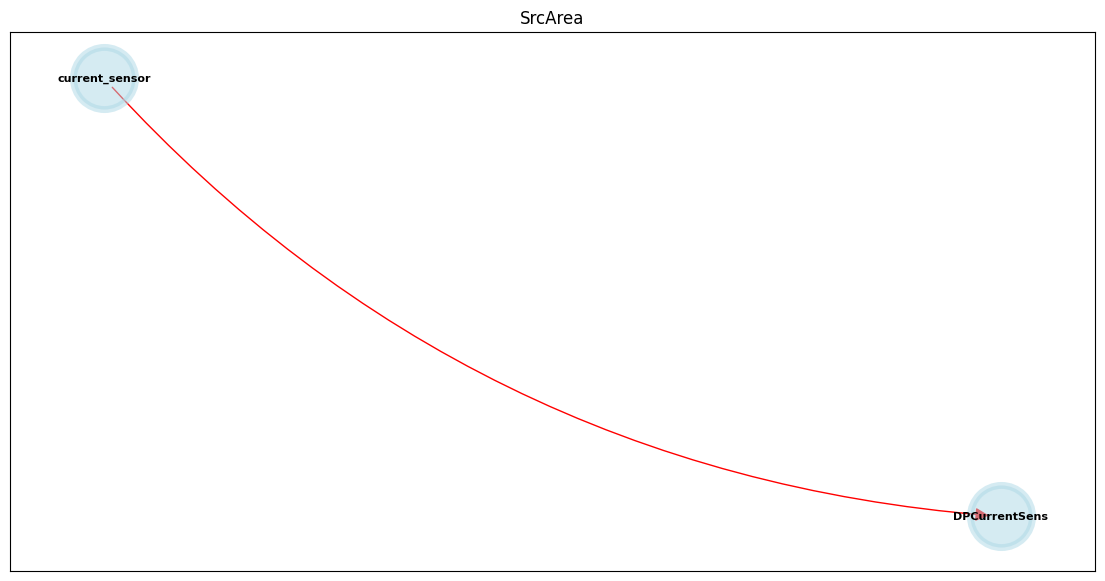

Defult triggers will be used, no triggers as input
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
Correct guard definition for trigger StoptriggerCosimArea916


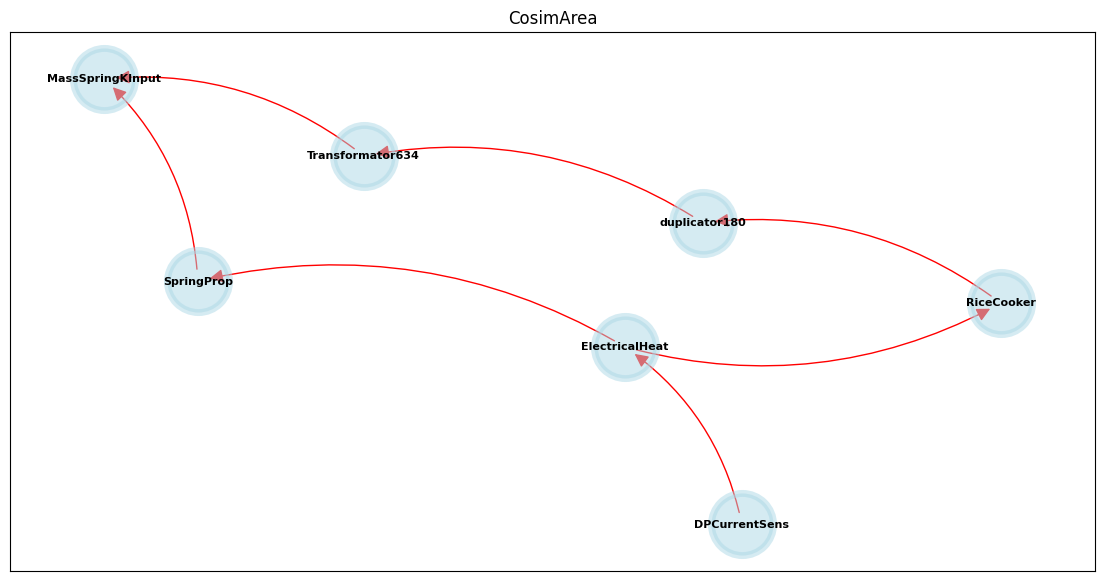

Defult triggers will be used, no triggers as input
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
*******************************************************************
DONT FORGET TO INCLUDE MANUALLY THE UNIQUE OBJECT OF THE APPLICATION CLOCK AND RE-RUN OBJ_GEN
******************************************************************
Correct guard definition for trigger StoptriggerSinkArea136


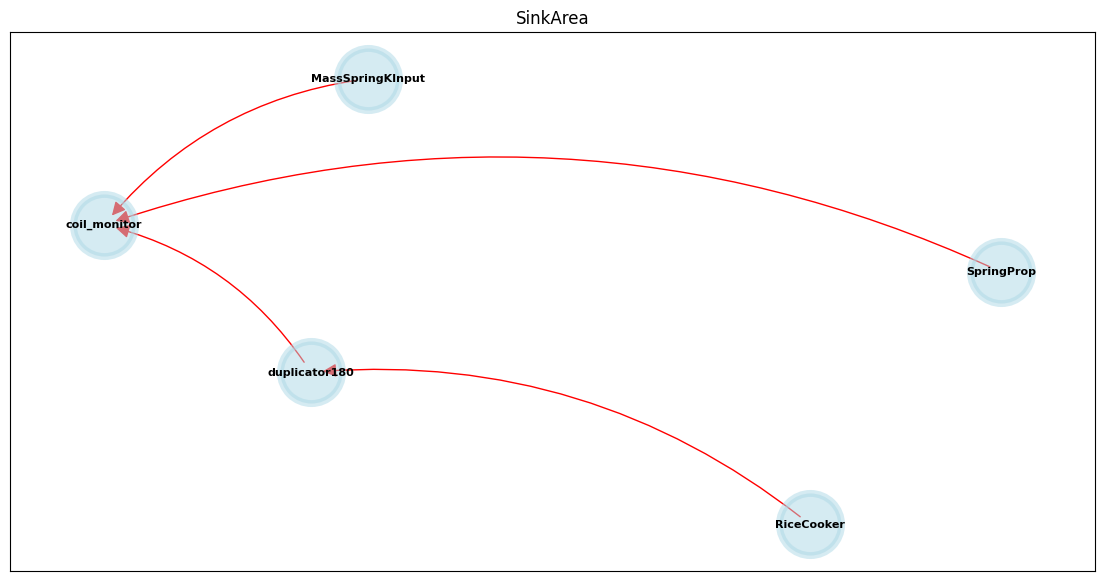

In [6]:
# Execution  manager
#generate and define all areas of execution

AppTime = GlOb.AppTime()
globals = GlOb.GlobalVars()

# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1)  transform(mass/Force)

#all componnets must be defined to feed the areas
allComponents = [globals,current_sens,coil_monitor,dataprocess1,
                 springProp,elecHeat,cookSpring,riceCooker,
                 dup1,transform]

areaSource = exeMgn.srcExe(name = 'SrcArea',components=[current_sens,dataprocess1],
                             exec_type='time_specific', triggers=[],allComponents=allComponents)

config = {'exeTime':'FTRT','exeConf':{'t_ini':(0,'s'),'t_period':(10,'s'), 't_step':(1,'s')}}

areaCosim =  exeMgn.cosim(name='CosimArea', components=[elecHeat,springProp,riceCooker,cookSpring,transform,dup1],
                            simexec_type='time_based',triggers=[],configuration=config,allComponents=allComponents)

areaSink = exeMgn.sinkExe(name = 'SinkArea', components=[coil_monitor],
                            exec_type='streaming',triggers=[],allComponents=allComponents)

In [7]:
print(areaCosim.areaInputs)
print(areaCosim.areaOutputs)
print(elecHeat.name)


{'ElectricalHeat': ['I']}
{'SpringProp': ['T_coil'], 'MassSpringKInput': ['DisplacementOutput'], 'duplicator180': ['mass1']}
ElectricalHeat


In [ ]:
identifier= ['ElectricalHeat.I']
dflag = GlOb.DataFlag(identifiers=identifier,allComponents=allComponents)

In [15]:
print(dflag.objects[0].state)

evaluate = dflag.evaluation()
print(evaluate)
dflag.objects[0].state = 'waiting'
print(dflag.objects[0].state)
evaluate = dflag.evaluation()
print(evaluate)

active
True
waiting
False


In [10]:
for comp in allComponents:
    print(comp.name)

globals
current_sensor
coil_monitor
DPCurrentSens
SpringProp
ElectricalHeat
MassSpringKInput
RiceCooker
duplicator180
Transformator634


In [11]:
# id:Conn0 ('current_sensor', 'current')->('DPCurrentSens', 'rawData')
# id:Conn1 ('DPCurrentSens', 'eCurrent')->('ElectricalHeat', 'I')
# id:Conn2 ('ElectricalHeat', 'Q')->('RiceCooker', 'Q')
# id:Conn3 ('ElectricalHeat', 'R')->('SpringProp', 'R')
# id:Conn4 ('RiceCooker', 'mass_rice')->('duplicator125', 'mass')
# id:Conn5 ('duplicator125', 'mass1')->('coil_monitor', 'mass')
# id:Conn6 ('duplicator125', 'mass0')->('Transformator972', 'mass')
# id:Conn7 ('Transformator972', 'Force')->('MassSpringKInput', 'Force')
# id:Conn8 ('SpringProp', 'k')->('MassSpringKInput', 'k')
# id:Conn9 ('SpringProp', 'T_coil')->('coil_monitor', 'T_coil')
# id:Conn10 ('MassSpringKInput', 'DisplacementOutput')->('coil_monitor', 'position')

In [12]:
# # Start server
# ports = [55000,55001,60001,60002,60000,60003,60004]
# server = Server(ports=ports)
# server.start_server()